# Load packages

In [173]:
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

In [174]:
# (auxilliary function for printing markdown)
def printmd(string):
    display(Markdown(string))

# Load event log

In [175]:
file = 'ArtificialPatientTreatment.csv'
# row = event about performing *activity* at *timestamp* concerning *patient case*
# (here, also incl. the *resource* involved; the consulting doctor)
events = pd.read_csv(file)

# also do some initial data prep
events.columns = ['patient', 'action', 'resource', 'timestamp']
events['timestamp'] = pd.to_datetime(events['timestamp'])
events['action'] = events['action'].apply(lambda x: x.strip())

# print out first few rows to get an idea of the data
events.head()


,patient,action,resource,timestamp
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


In [176]:
print('{} has {} rows and {} columns.'.format(file, events.shape[0], events.shape[1]))

ArtificialPatientTreatment.csv has 690 rows and 4 columns.


# Log preparation

In [177]:
# - per case, get the start and end times

# (start & end times of patient cases =  min. and max. value of all timestamps per patient, respectively)
case_starts_ends = events.pivot_table(index='patient', aggfunc={'timestamp': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart']
# (add these new columns to event table)
events = events.merge(case_starts_ends, on='patient')


# - per event, get relative time since start of case

events['relativetime'] = events['timestamp'] - events['casestart']
events.head()

,patient,action,resource,timestamp,caseend,casestart,relativetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58


# Extend event log with extra attributes

In [178]:
# - per case, add attributes to event log:
# (1) single string with sequence of activities (action_sequence)
# (2) count total number of events (numactions)

delimiter = '___'

makeEventString = lambda x: delimiter.join(x)
makeEventString.__name__ = 'makeEventString'

numEvents = lambda x: len(x)
numEvents.__name__ = 'numEvents'

caselogs = events.pivot_table(index='patient', aggfunc={'action': [makeEventString, numEvents]})
caselogs = caselogs.reset_index()
caselogs.columns = ['patient', 'action_sequence', 'numactions']

events = pd.merge(events, caselogs, on='patient')
events['caselength'] = events['caseend'] - events['casestart']

events.head()


,patient,action,resource,timestamp,caseend,casestart,relativetime,action_sequence,numactions,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,First consult___Blood test___Physical test___S...,6,6 days 20:49:17


In [179]:
# - per event, add weekday, date & hour of timestamp; date of start-time; seconds & days of relative time

events['weekday'] = events['timestamp'].apply(lambda x: x.weekday())
events['date'] = events['timestamp'].apply(lambda x: x.date())
events['hour'] = events['timestamp'].apply(lambda x: x.time().hour)
events['startdate'] = events['casestart'].apply(lambda x: x.date())
## Get relative times in more friendly terms
events['relativetime_s'] = events['relativetime'].dt.seconds + 86400*events['relativetime'].dt.days
events['relativedays'] = events['relativetime'].dt.days

events.head()

,patient,action,resource,timestamp,caseend,casestart,relativetime,action_sequence,numactions,caselength,weekday,date,hour,startdate,relativetime_s,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,11,2017-01-02,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,12,2017-01-02,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,12,2017-01-02,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,16,2017-01-02,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,3,2017-01-05,13,2017-01-02,265378,3


# Questions
Ask some questions about the dataeset.

## What is the minimum number of events per case?

In [180]:
printmd('**Minimum number of events per case**: {}'.format(min(events['patient'].value_counts())))

**Minimum number of events per case**: 6

## Patient 26
* Which doctor did they have their first & last consultation with?

In [181]:
first_doctor = events[events['timestamp']==min(events[events['patient']=='patient 26']['timestamp'])]['resource'].values[0]
last_doctor = events[events['timestamp']==max(events[events['patient']=='patient 26']['timestamp'])]['resource'].values[0]
printmd('**First doctor**: {}'.format(first_doctor))
printmd('**Last doctor**: {}'.format(last_doctor))

**First doctor**:  Dr. Bob

**Last doctor**:  Dr. Ben

## Which activity has the lowest occurrence overall in the event log?

In [182]:
printmd('**Activity with lowest occurrence**: {}'.format(events['action'].value_counts().sort_values().idxmin()))

**Activity with lowest occurrence**: Surgery

# Visualisations

In [183]:
# - select all events belonging to first 50 patients

patients = events['patient'].unique()
selected_patients = patients[0:50]
patientX = events[events['patient'].isin(selected_patients)]

In [184]:
# - prepare some lists for visualization

# per event, get patient case ids (used to setup Y axis ticks)
patientnums = [int(e) for e in events['patient'].apply(lambda x: x.strip('patient'))]
# per event, get ordinal for resource (used in later code)
resourcenums = [i for (i, e) in enumerate(events['resource'])]

## Simple scatter plots

### Date

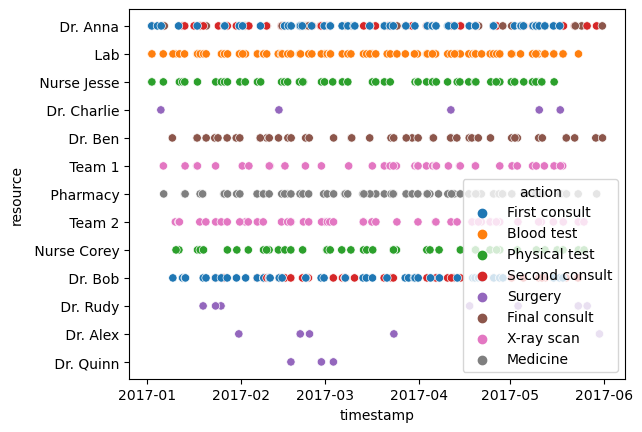

In [185]:
# - plot resource usage over time

ax = sns.scatterplot(x=events['timestamp'], y=events['resource'], hue=events['action'])

### Relative time 
Time since start of case.

* y-axis represents each patient case.
* x-axis represents time since case was initiated.
* Different marker colors represent different actions.

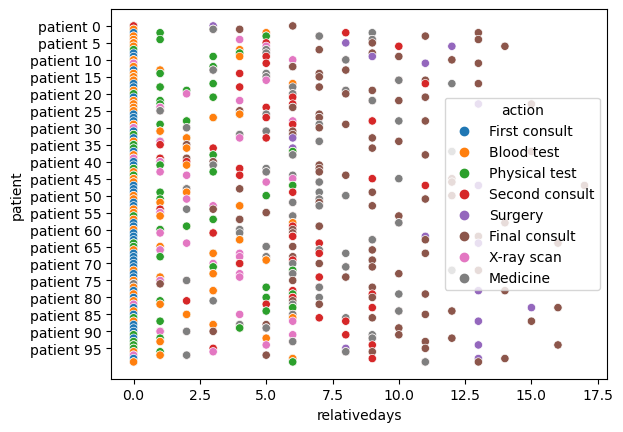

In [186]:
# - per patient case, time in days per activity

ax = sns.scatterplot(x=events['relativedays'], y=events['patient'], hue=events['action'])
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));


In [187]:
# - sort events by case length and relative time to start

ordered = events.sort_values(by=['caselength', 'relativedays'])

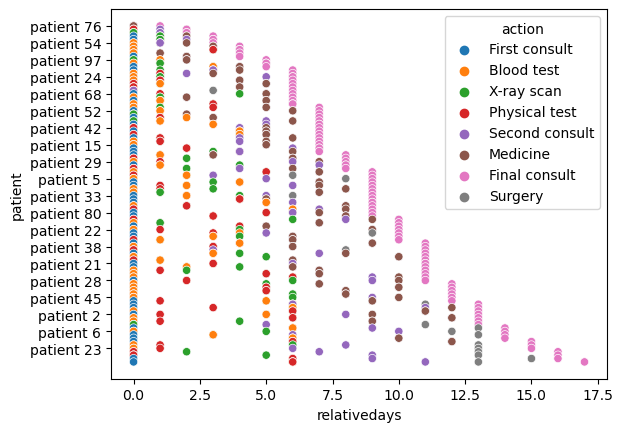

In [188]:
# - now, per patient case, time in days per activity (sorted events)

ax = sns.scatterplot(x=ordered['relativedays'], y=ordered['patient'], hue=ordered['action'])
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));
plt.show()


# Get case data per patient (interactive)

In [189]:
# (widget libraries)
from ipywidgets import widgets
from ipywidgets import interact, interact_manual

patients = events['patient'].unique()

@interact
def getCaseData(x=patients):
    return events[events['patient']==x]

interactive(children=(Dropdown(description='x', options=('patient 0', 'patient 1', 'patient 2', 'patient 3', '…

# Filtering events

## Getting events that are (not) common to all patients

**The following actions are common to all cases**: Blood test, Final consult, First consult, Physical test, Second consult

**The following actions are not common to all cases**: Medicine, Surgery, X-ray scan

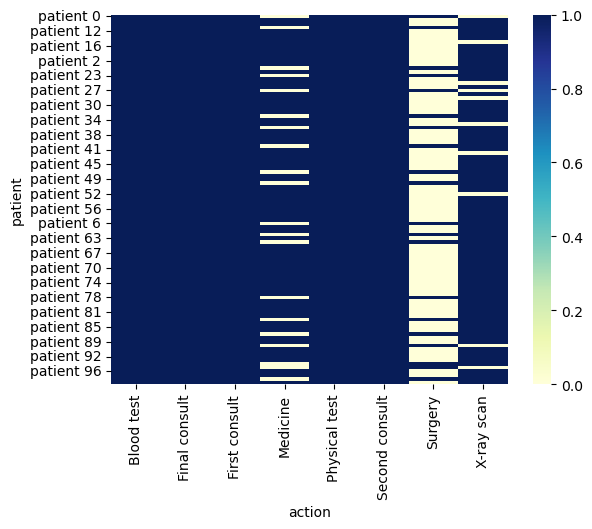

In [190]:
# get frequency table (rows = patient cases; columns = actions; values = number of times action occurs for case)
patient_events = pd.crosstab(events['patient'], events['action'])

# create heat map
sns.heatmap(patient_events, cmap="YlGnBu")

# per column (action), get number of unique values
nunique = patient_events.apply(pd.Series.nunique)

common_actions = nunique[nunique==1].index # (means only 1's are found)
uncommon_actions = nunique[nunique>1].index # (means both 0's and 1's are found)
printmd('**The following actions are common to all cases**: {}'.format(', '.join(common_actions)))
printmd('**The following actions are not common to all cases**: {}'.format(', '.join(uncommon_actions)))


## Filter events to only include uncommon events

**The filtered data has** 190 **rows and** 16 **columns.**

**This amounts to** 100 **cases with** 3 **distinct actions.**

**The filtered data excluding X-rays has** 100 **rows and** 16 **columns.**

<Axes: xlabel='action', ylabel='patient'>

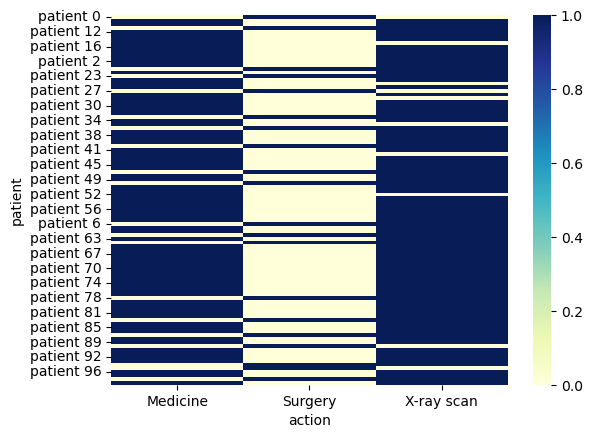

In [191]:
filtered = events[events['action'].isin(uncommon_actions)]
patient_events = pd.crosstab(filtered['patient'], filtered['action'])

printmd('**The filtered data has** {} **rows and** {} **columns.**'.format(filtered.shape[0], filtered.shape[1]))
printmd('**This amounts to** {} **cases with** {} **distinct actions.**'.format(patient_events.shape[0], patient_events.shape[1]))

# minus x-ray scans?
filtered = filtered[filtered['action']!='X-ray scan']
printmd('**The filtered data excluding X-rays has** {} **rows and** {} **columns.**'.format(filtered.shape[0], filtered.shape[1]))

# filtered heat map
sns.heatmap(patient_events, cmap="YlGnBu")

# Process Mining
* Check out this [introduction to process mining in Python](https://towardsdatascience.com/introduction-to-process-mining-5f4ce985b7e5).
* [Documentation for pm4py](https://pm4py.fit.fraunhofer.de/)

## Load packages

In [192]:
# run the following in terminal:
# %> pip install pm4py

import pm4py

# converters
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.filtering.dfg.dfg_filtering import clean_dfg_based_on_noise_thresh

# social network analysis
from pm4py.algo.organizational_mining.sna import algorithm as sna_algorithm
from pm4py.visualization.sna import visualizer as pn_vis

# visualization
# (wvw: updated, courtesy https://stackoverflow.com/questions/75424412/no-module-named-pm4py-objects-petri-in-pm4py)
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
# (wvw: added)
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer

# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.petri_net.util import performance_map 

## Log preparation

In [193]:
eventlog = events.copy()

# rename columns in accordance with pm4py
# specify columns corresponding to case (case:concept:name), event (concept:name) & timestamp (time:timestamp)

eventlog.rename(columns={'timestamp': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

# convert to log format
log = log_converter.apply(eventlog)

eventlog.head()

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,action_sequence,numactions,caselength,weekday,date,hour,startdate,relativetime_s,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,11,2017-01-02,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,12,2017-01-02,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,12,2017-01-02,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,16,2017-01-02,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,3,2017-01-05,13,2017-01-02,265378,3


## Process mining algorithms

### Directly-follows graph

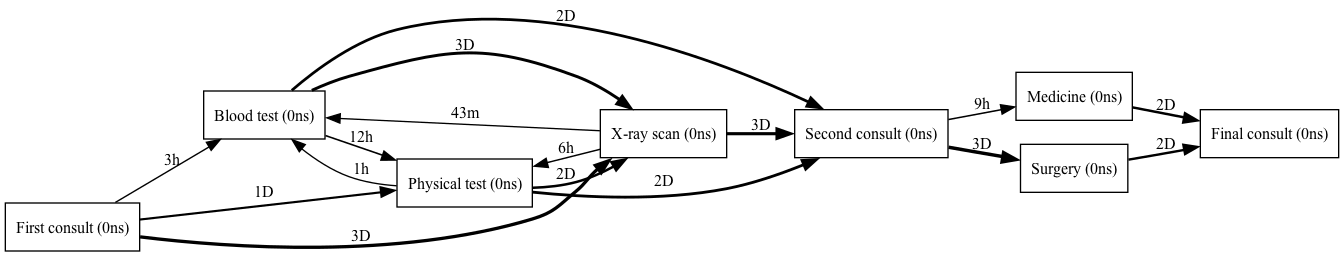

In [194]:
# create graph from log
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)

# visualize performance (durations)
gviz = dfg_visualizer.apply(dfg, log=log, variant=dfg_visualizer.Variants.PERFORMANCE)
dfg_visualizer.view(gviz)

# admire the spaghetti ...

With average times between nodes (performance)

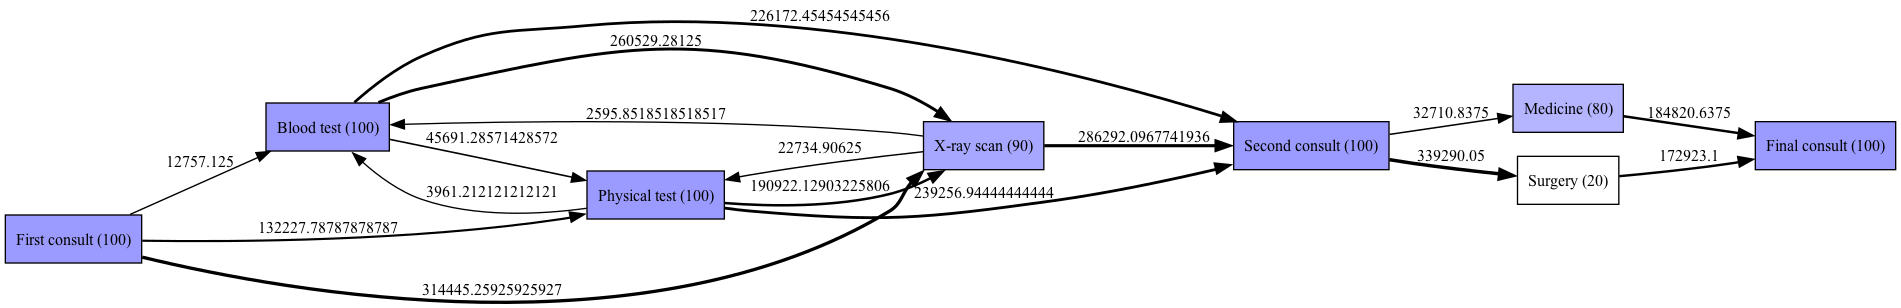

In [195]:
# visualize performance (frequency)

gviz = dfg_visualizer.apply(dfg, log=log, variant=dfg_visualizer.Variants.FREQUENCY)
dfg_visualizer.view(gviz)

### Alpha miner

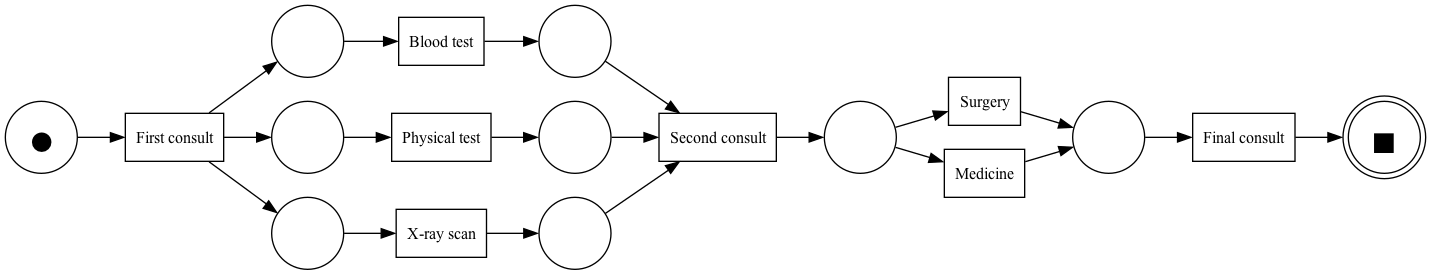

In [196]:
# alpha miner
net, initial_marking, final_marking = alpha_miner.apply(log)

# visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

# better!

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

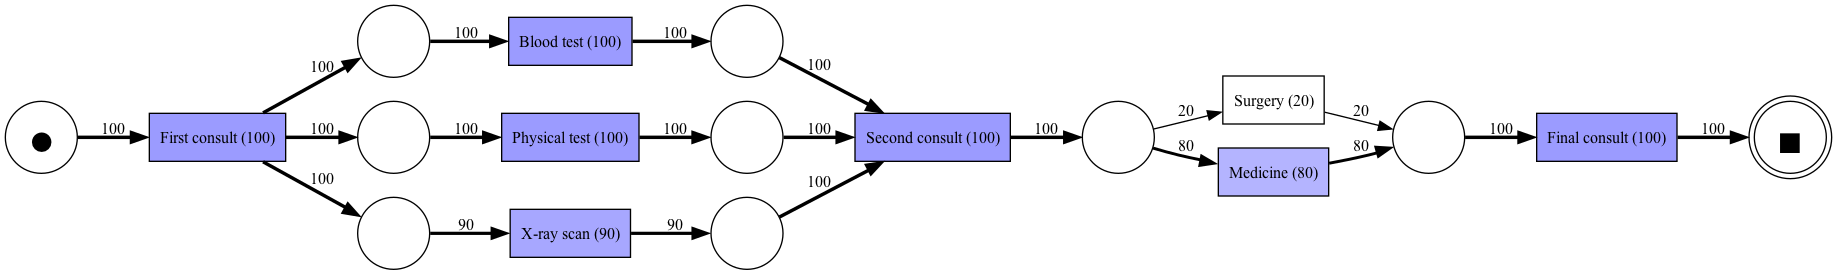

In [197]:
# add frequency to visualization
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

pn_visualizer.view(gviz)

# (save the Petri net)
# pn_visualizer.save(gviz, "alpha_miner_healthcare_petri_net.png")


# compare with heat map with uncommon events:
# (medicine is slightly less "popular" than x-rays, and surgery is least popular)

### Heuristic miner

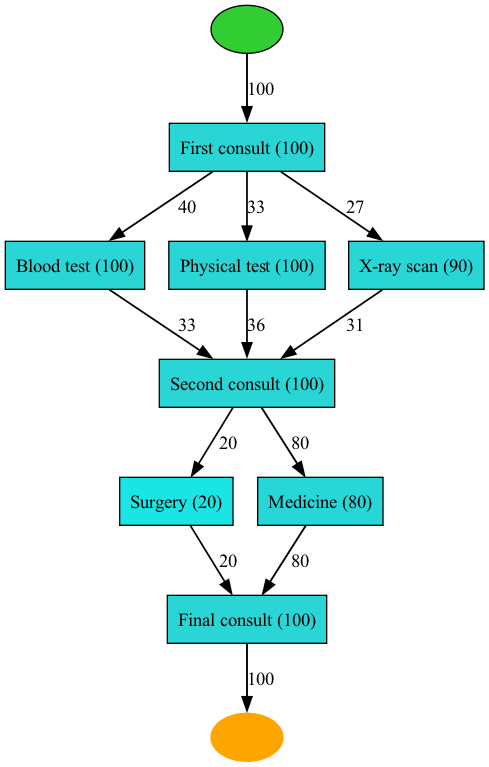

In [198]:
# heuristics miner
heu_net = heuristics_miner.apply_heu(log)

# visualize
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

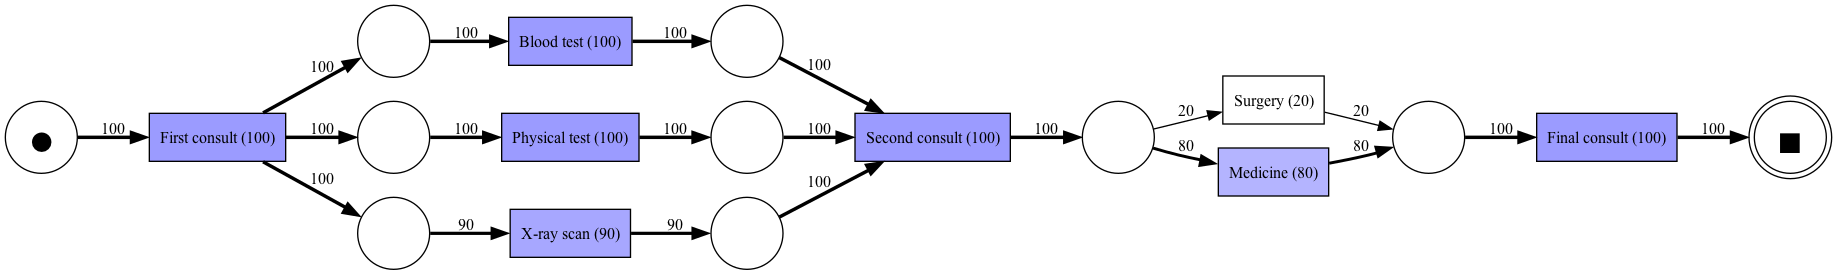

In [199]:
# show petri net (same output as alpha miner), incl. frequencies

# heuristics miner
net, im, fm = heuristics_miner.apply(log)

# visualize
gviz = pn_visualizer.apply(net, im, fm, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)
pn_visualizer.view(gviz)

### Inductive miner

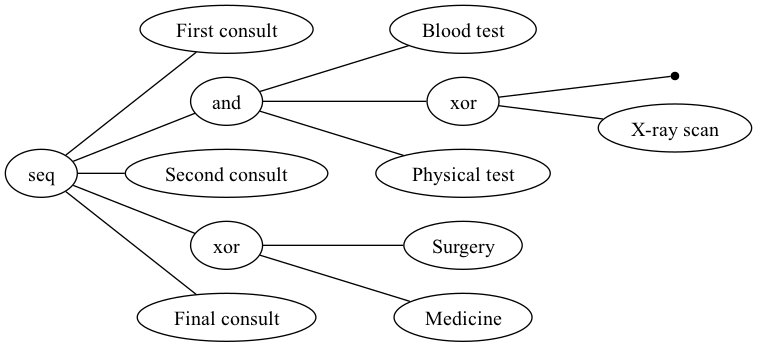

In [200]:
# create the process tree
# (wvw: drop "_tree" from call)
tree = inductive_miner.apply(log)

# visualize
gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)

# creates a process treee instead of petri net

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

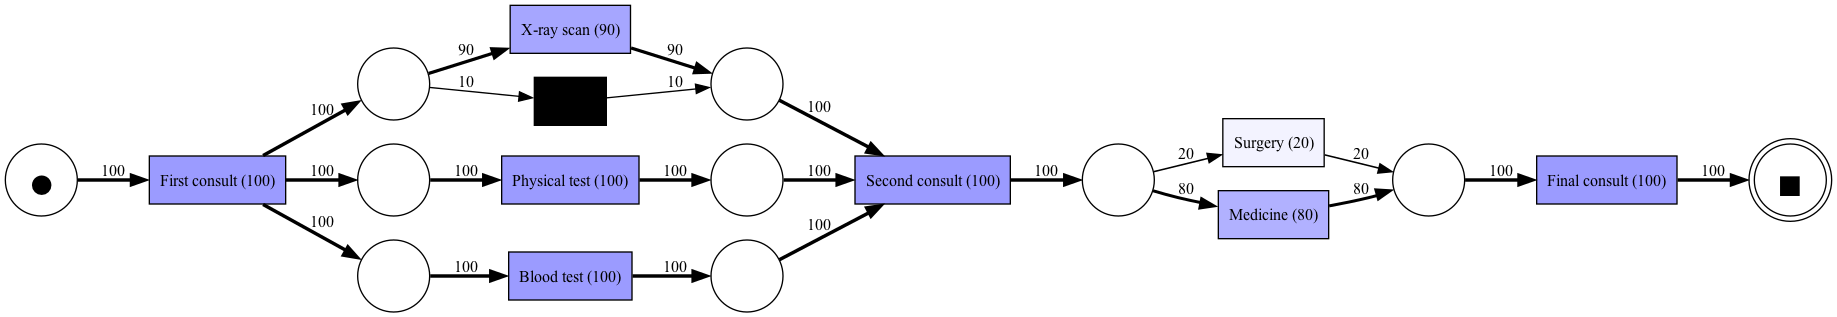

In [201]:
# show petri net, incl. frequencies

# (wvw - only process tree mining seems to be supported currently)

# convert the process tree to a petri net
net, initial_marking, final_marking = pt_converter.apply(tree)


# (wvw: not working for me)
# alternatively, use the inductive_miner to create a petri net from scratch
# net, initial_marking, final_marking = inductive_miner.apply(log)

# viz
# parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                        #    parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)
pn_visualizer.view(gviz)

# pn_visualizer.save(gviz, "inductive_miner_healthcare_petri_net.png")

## Variants

Get unique process variants, i.e., unique sequences of activities.

In [202]:
variants = pm4py.get_variants(log)
variants = pd.DataFrame(variants.items())

variants

/Users/wvw/anaconda3/lib/python3.11/site-packages/pm4py/utils.py:536: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


,0,1
0,"(First consult, Blood test, Physical test, Sec...","[[[concept:name, org:resource, time:timestamp,..."
1,"(First consult, Physical test, Blood test, X-r...","[[[concept:name, org:resource, time:timestamp,..."
2,"(First consult, Physical test, X-ray scan, Blo...","[[[concept:name, org:resource, time:timestamp,..."
3,"(First consult, Blood test, X-ray scan, Physic...","[[[concept:name, org:resource, time:timestamp,..."
4,"(First consult, Blood test, Physical test, X-r...","[[[concept:name, org:resource, time:timestamp,..."
5,"(First consult, Physical test, X-ray scan, Blo...","[[[concept:name, org:resource, time:timestamp,..."
6,"(First consult, Physical test, Blood test, X-r...","[[[concept:name, org:resource, time:timestamp,..."
7,"(First consult, X-ray scan, Blood test, Physic...","[[[concept:name, org:resource, time:timestamp,..."
8,"(First consult, Physical test, Blood test, Sec...","[[[concept:name, org:resource, time:timestamp,..."
9,"(First consult, X-ray scan, Physical test, Blo...","[[[concept:name, org:resource, time:timestamp,..."


## Social Networks

* See [this guide](https://pm4py.fit.fraunhofer.de/documentation#social-network-analysis) on using pm4py to analyse social networks

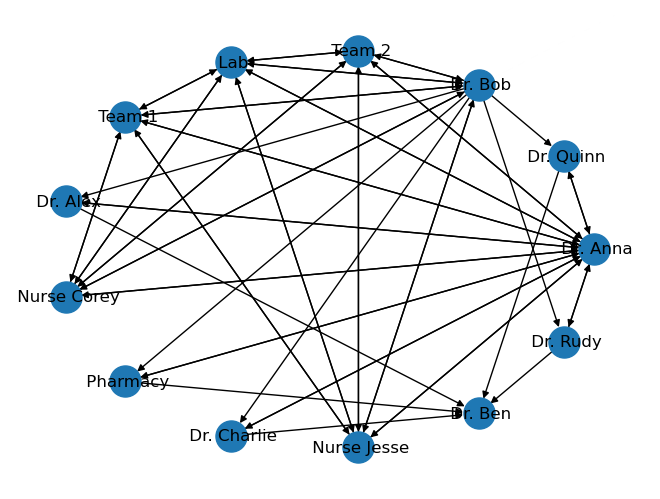

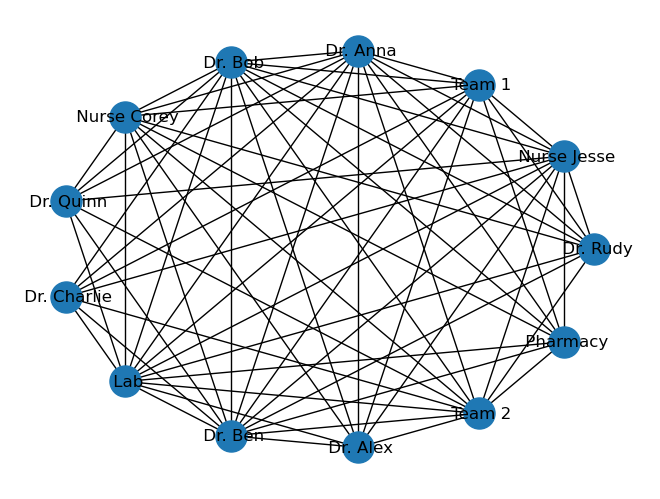

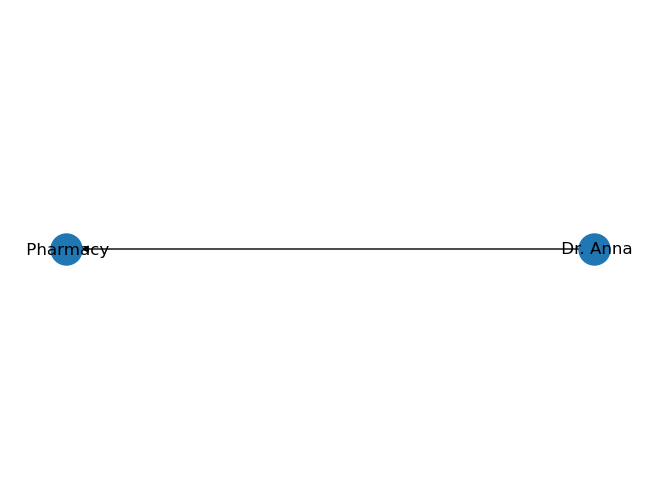

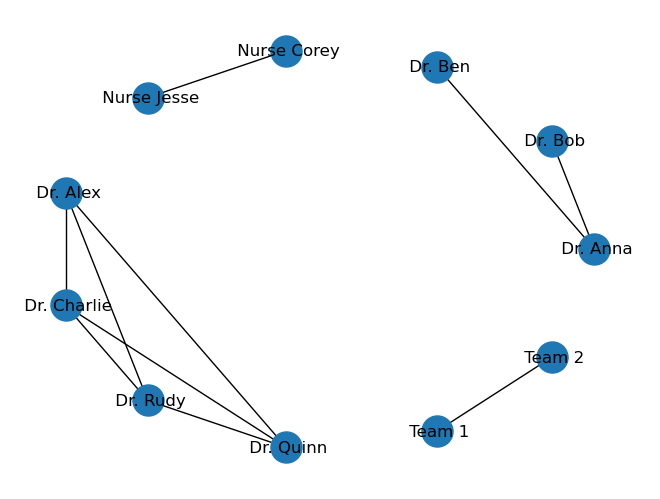

In [203]:
# different types of social interactions
hw_values = sna_algorithm.apply(log, variant=sna_algorithm.Variants.HANDOVER_LOG)
wt_values = sna_algorithm.apply(log, variant=sna_algorithm.Variants.WORKING_TOGETHER_LOG)
sub_values = sna_algorithm.apply(log, variant=sna_algorithm.Variants.SUBCONTRACTING_LOG)
ja_values = sna_algorithm.apply(log, variant=sna_algorithm.Variants.JOINTACTIVITIES_LOG)

gviz_hw = pn_vis.apply(hw_values, variant=pn_vis.Variants.NETWORKX,
                       parameters={pn_vis.Variants.NETWORKX.value.Parameters.FORMAT: "png"})
gviz_wt = pn_vis.apply(wt_values, variant=pn_vis.Variants.NETWORKX,
                       parameters={pn_vis.Variants.NETWORKX.value.Parameters.FORMAT: "png"})
gviz_sub = pn_vis.apply(sub_values, variant=pn_vis.Variants.NETWORKX,
                        parameters={pn_vis.Variants.NETWORKX.value.Parameters.FORMAT: "png"})
gviz_ja = pn_vis.apply(ja_values, variant=pn_vis.Variants.NETWORKX,
                       parameters={pn_vis.Variants.NETWORKX.value.Parameters.FORMAT: "png"})

pn_vis.view(gviz_hw, variant=pn_vis.Variants.NETWORKX)
pn_vis.view(gviz_wt, variant=pn_vis.Variants.NETWORKX)
pn_vis.view(gviz_sub, variant=pn_vis.Variants.NETWORKX)
pn_vis.view(gviz_ja, variant=pn_vis.Variants.NETWORKX)

# Extra material

I did not find the code below very useful, including it here for completeness

## Simple scatter plots


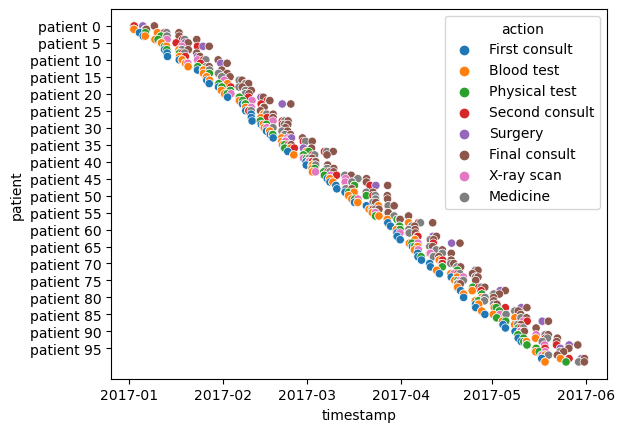

In [204]:
ax = sns.scatterplot(x=events['timestamp'], y=events['patient'], hue=events['action'])
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));

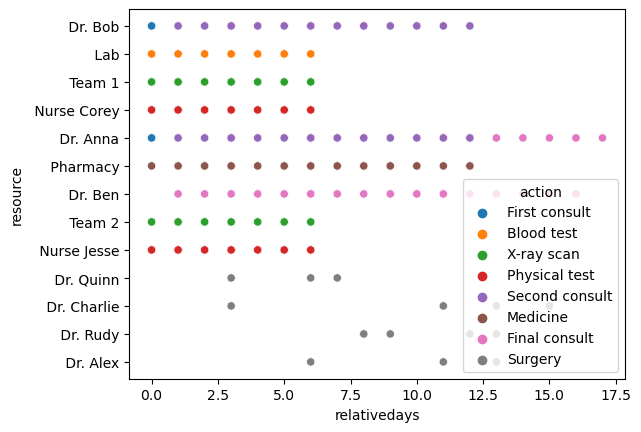

In [205]:
# - per resource, time in days per activity (sorted events)

ax = sns.scatterplot(x=ordered['relativedays'], y=ordered['resource'], hue=ordered['action'])
plt.show()


In [206]:
pd.crosstab(events['action'], events['resource'], normalize='columns')

resource,Dr. Alex,Dr. Anna,Dr. Ben,Dr. Bob,Dr. Charlie,Dr. Quinn,Dr. Rudy,Lab,Nurse Corey,Nurse Jesse,Pharmacy,Team 1,Team 2
action,,,,,,,,,,,,,
Blood test,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Final consult,0.0,0.316456,1.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
First consult,0.0,0.335443,0.0,0.51087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Medicine,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Physical test,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
Second consult,0.0,0.348101,0.0,0.48913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Surgery,1.0,0.000000,0.0,0.00000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
X-ray scan,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


## Simple stripplots

### Weekday

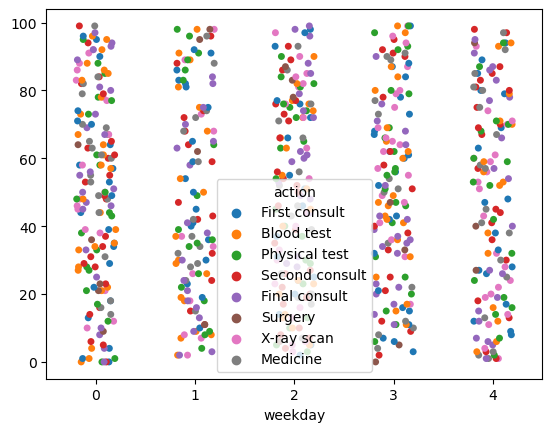

In [207]:
# - Y axis = patient ordinal; X axis = weekday; dots = action

ax = sns.stripplot(x=events['weekday'], y=patientnums, hue=events['action'], jitter=0.2)
#plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));

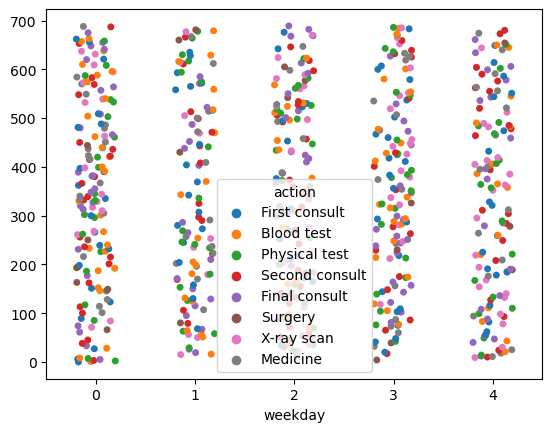

In [208]:
# - Y axis = resource ordinal; X axis = weekday; dots = action

ax = sns.stripplot(x=events['weekday'], y=resourcenums, hue=events['action'], jitter=0.2)

### Hour

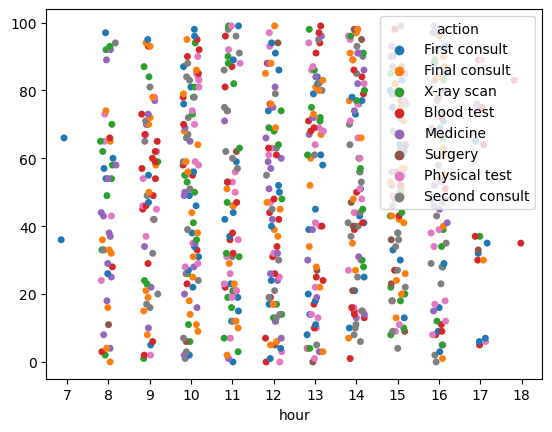

In [209]:
# - Y axis = patient ordinal; X axis = hour; dots = action

ax = sns.stripplot(x=events['hour'], y=patientnums, hue=events['action'], jitter=0.2)


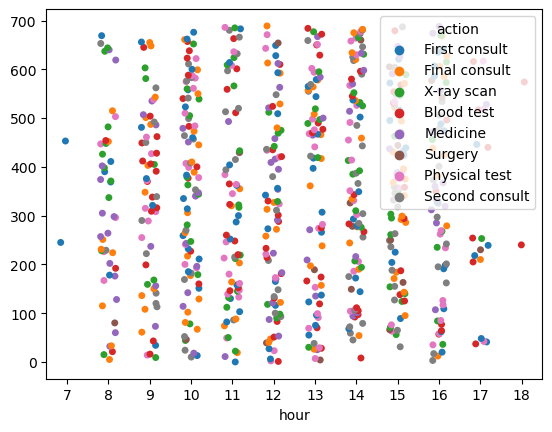

In [210]:
# - Y axis = resource ordinal; X axis = hour; dots = action

ax = sns.stripplot(x=events['hour'], y=resourcenums, hue=events['action'], jitter=0.2)

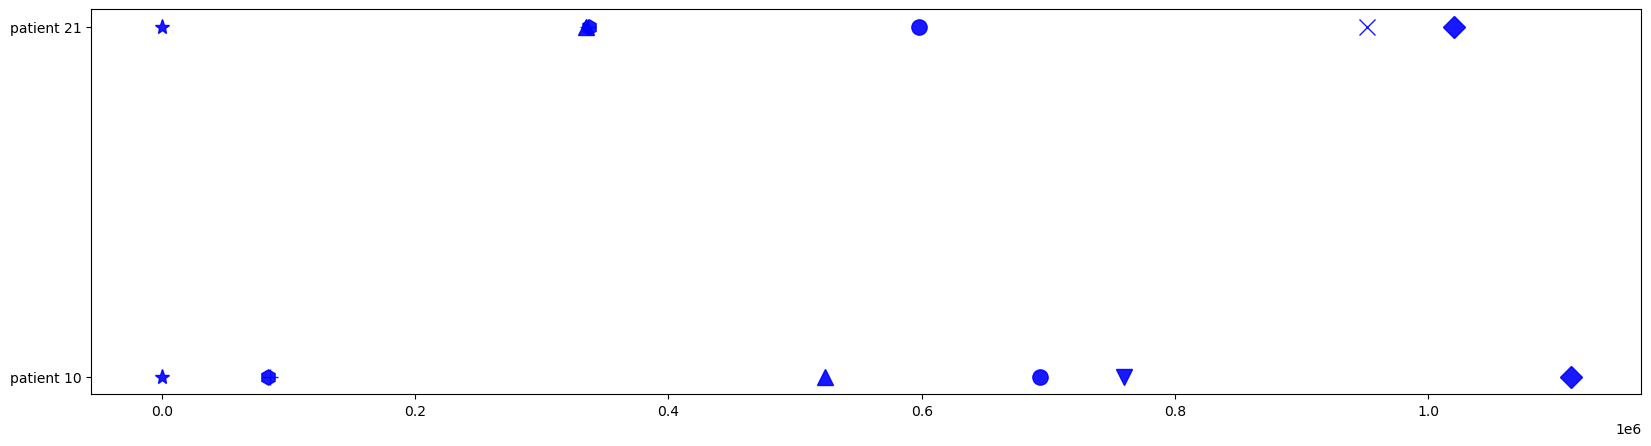

In [211]:
# - use unique markers per activity

activities = list(events['action'].unique())
markers = ['*', '+', 'h', 'o', 'x', 'D', '^', 'v']

# (same # of markers as # of activities)
assert(len(activities)==len(markers))

def getEventPlot(patientlist=[patients[10], patients[21]]):
    fig, ax = plt.subplots(figsize=(20, 5))
    
    for x in patientlist:
        patientX = getCaseData(x)
        
    
        for i in range(0, len(activities)):
            a = activities[i]
            marker = markers[i]
            selected = patientX[patientX['action']==a]
            ax.plot(selected['relativetime_s'], 
                selected['patient'],
                marker=marker, markersize=11,
                alpha=0.9, color='blue', linewidth=0, 
                label=a);
    plt.show()

getEventPlot()